In [1]:
import numpy as np
import pytorch_lightning as pl
import torch
import torch.nn.functional as F
import umap
import hdbscan
from hdbscan.flat import (HDBSCAN_flat,
                          approximate_predict_flat,
                          membership_vector_flat,
                          all_points_membership_vectors_flat)
from sklearn import cluster
import seaborn as sns
from unsupervised_meta_learning.re_rank import re_ranking, re_ranking2
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
pl.seed_everything(42)

Global seed set to 42


42

In [3]:
z = torch.load('./data/z.pt')
labels = torch.load('./data/labels.pt')

In [4]:
z.requires_grad = False

In [5]:
z.squeeze_(0)
labels.squeeze_(0)
z.shape, labels.shape

(torch.Size([800, 1600]), torch.Size([800]))

In [6]:
z = F.normalize(z).numpy()

In [7]:
y_query = torch.arange(200).unsqueeze(0).unsqueeze(2)  # batch and shot dim
y_query = y_query.repeat(1, 1, 3)
y_query = y_query.view(1, -1).long()

y_support = torch.arange(200).unsqueeze(0).unsqueeze(2)  # batch and shot dim
y_support = y_support.repeat(1, 1, 1)
y_support = y_support.view(1, -1).long()

In [8]:
y = torch.cat([y_support, y_query], axis=1)
y = y.flatten().numpy()

In [9]:
z_reduced = umap.UMAP(
                    random_state=42,
                    n_components=2,
                    min_dist=0.25,
                    n_neighbors=50).fit_transform(z, y=y)

<AxesSubplot:>

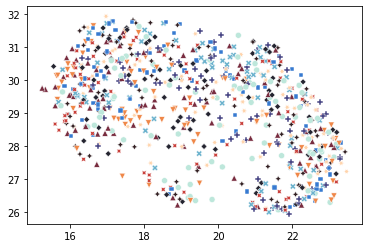

In [32]:
sns.scatterplot(x=z_reduced[:, 0], y=z_reduced[:, 1], hue=labels, style=labels, palette="icefire", legend=False)

## Z_Reduced

In [33]:
dists = re_ranking(z_reduced, z_reduced, k1=15, k2=3, lambda_value=0)

computing original distance
starting re_ranking


In [11]:
dists2 = re_ranking2(z_reduced, z_reduced, k1=15, k2=3, lambda_value=0)

Computing original distance...
Starting re_ranking...


In [12]:
tri_mat = np.triu(dists2, 1) # tri_mat.dim=2
tri_mat = tri_mat[np.nonzero(tri_mat)] # tri_mat.dim=1
tri_mat = np.sort(tri_mat,axis=None)
top_num = np.round(0.6*tri_mat.size).astype(int)
eps = tri_mat[:top_num].mean()
eps

0.975

In [36]:
clf = cluster.DBSCAN(eps=eps, min_samples=70, metric='precomputed', n_jobs=8)
preds = clf.fit_predict(dists2)
np.unique(preds, return_counts=True)

(array([-1,  0]), array([ 48, 752]))

<AxesSubplot:>

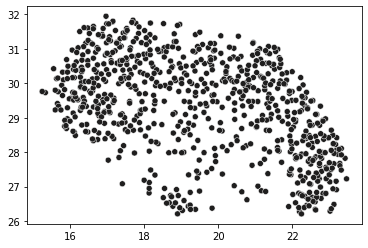

In [37]:
sns.scatterplot(x=z_reduced[preds >= 0, 0], y=z_reduced[preds >= 0, 1], hue=preds[preds >= 0], style=preds[preds >= 0], palette="icefire", legend=False)

In [38]:
clf = hdbscan.HDBSCAN(min_cluster_size=8, metric='precomputed')
preds = clf.fit_predict(dists2.astype(float))
np.unique(preds, return_counts=True)

(array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
        16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]),
 array([209,  38,  11,  15,  20,  60,  19,  12,  27,  21,  10,  14,  36,
         11,  17,  11,  14,  10,  14,  41,  38,  20,  23,  10,  16,  13,
          8,  22,  20,  10,  10]))

<AxesSubplot:>

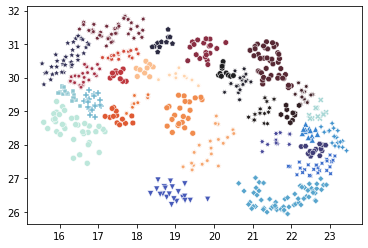

In [39]:
sns.scatterplot(
    x=z_reduced[preds >= 0, 0],
    y=z_reduced[preds >= 0, 1],
    hue=preds[preds >= 0],
    style=preds[preds >= 0],
    palette="icefire",
    legend=False
)

In [40]:
clf = cluster.KMeans(n_clusters=10)
preds = clf.fit_predict(z_reduced)
np.unique(preds, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int32),
 array([ 84,  76,  97,  95,  86, 115,  41,  58,  60,  88]))

<AxesSubplot:>

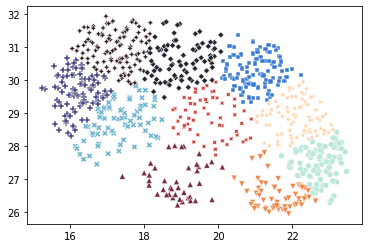

In [42]:
sns.scatterplot(
    x=z_reduced[:, 0],
    y=z_reduced[: ,1],
    hue=preds,
    style=preds,
    palette="icefire",
    legend=False
)

In [15]:
clf = cluster.SpectralClustering(n_clusters=15, affinity='precomputed', eigen_solver='amg')
preds = clf.fit_predict(dists2)
np.unique(preds, return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14],
       dtype=int32),
 array([ 92,  72,  56,  24,  27,  85,  85,  44, 118,   9,  54,   1,   6,
         52,  75]))

<AxesSubplot:>

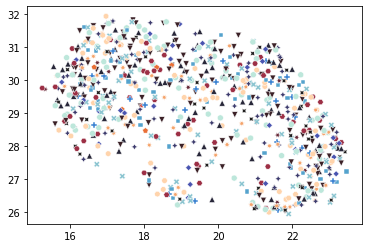

In [16]:
sns.scatterplot(
    x=z_reduced[:, 0],
    y=z_reduced[: ,1],
    hue=preds,
    style=preds,
    palette="icefire",
    legend=False
)

## ZR^3 - 3 dims suck

In [64]:
zr3 = umap.UMAP(
                random_state=42,
                n_components=3,
                min_dist=0.25,
                n_neighbors=50).fit_transform(z, y=y)

In [65]:
dzr3 = re_ranking2(zr3, zr3, k1=15, k2=3, lambda_value=0)

Computing original distance...
Starting re_ranking...


In [66]:
tri_mat = np.triu(dzr3, 1) # tri_mat.dim=2
tri_mat = tri_mat[np.nonzero(tri_mat)] # tri_mat.dim=1
tri_mat = np.sort(tri_mat,axis=None)
top_num = np.round(0.6*tri_mat.size).astype(int)
eps = tri_mat[:top_num].mean()
eps

0.975

In [67]:
clf = cluster.DBSCAN(eps=eps, min_samples=80, metric='precomputed', n_jobs=8, )
preds = clf.fit_predict(dzr3)
np.unique(preds, return_counts=True)

(array([-1,  0]), array([ 95, 705]))

<AxesSubplot:>

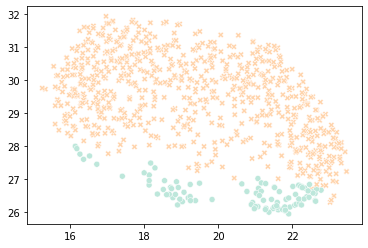

In [68]:
sns.scatterplot(x=z_reduced[:, 0], y=z_reduced[:, 1], hue=preds, style=preds, palette="icefire", legend=False)

In [72]:
clf = hdbscan.HDBSCAN(min_cluster_size=70, metric='precomputed', cluster_selection_epsilon=eps.item())
preds = clf.fit_predict(dzr3.astype(float))
np.unique(preds, return_counts=True)

(array([-1,  0,  1]), array([  1, 724,  75]))

<AxesSubplot:>

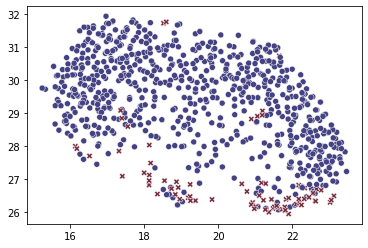

In [73]:
sns.scatterplot(
    x=z_reduced[preds >= 0, 0],
    y=z_reduced[preds >= 0, 1],
    hue=preds[preds >= 0],
    style=preds[preds >= 0],
    palette="icefire",
    legend=False
)

## True Z

In [55]:
dists = re_ranking(z.numpy(), z.numpy(), k1=20, k2=6, lambda_value=.3)

computing original distance
starting re_ranking


In [62]:
dists2 = re_ranking2(z.numpy(), z.numpy(), lambda_value=0)

Computing original distance...
Starting re_ranking...


In [33]:
tri_mat = np.triu(dists, 1) # tri_mat.dim=2
tri_mat = tri_mat[np.nonzero(tri_mat)] # tri_mat.dim=1
tri_mat = np.sort(tri_mat,axis=None)
top_num = np.round(0.6*tri_mat.size).astype(int)

In [34]:
eps = tri_mat[:top_num].mean()
eps

0.9014

In [37]:
float(eps)

0.9013671875

In [44]:
dists.astype(float)

array([[ 0.00000000e+00,  8.56445312e-01,  8.08105469e-01, ...,
         9.24804688e-01,  9.23339844e-01,  9.23339844e-01],
       [ 8.56445312e-01,  4.39405441e-04,  7.88085938e-01, ...,
         9.22851562e-01,  9.20410156e-01,  9.18945312e-01],
       [ 8.06640625e-01,  7.86132812e-01,  4.39405441e-04, ...,
         9.15527344e-01,  9.14062500e-01,  9.18457031e-01],
       ...,
       [ 9.17480469e-01,  9.16015625e-01,  9.12109375e-01, ...,
        -1.75762177e-03,  9.01855469e-01,  9.15039062e-01],
       [ 9.16503906e-01,  9.15039062e-01,  9.11132812e-01, ...,
         9.01855469e-01,  0.00000000e+00,  9.14550781e-01],
       [ 9.26269531e-01,  9.21875000e-01,  9.22851562e-01, ...,
         9.24316406e-01,  9.22851562e-01,  0.00000000e+00]])

In [45]:
preds = hdbscan.HDBSCAN(metric='precomputed', n_jobs=6, min_cluster_size=3).fit_predict(dists.astype(float))

In [46]:
np.unique(preds, return_counts=True)

(array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
        16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32,
        33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49,
        50, 51, 52, 53, 54, 55, 56, 57, 58]),
 array([414,   9,   3,   3,   3,  12,   6,   3,   3,   5,   4,   4,   4,
          4,   8,   9,   3,   4,   4,   4,   6,   6,   6,   4,   8,   5,
          5,  13,   3,   7,   5,   6,   4,  17,   8,   4,   5,   4,   5,
          4,   9,   6,   9,   5,   5,  16,   8,   5,   5,   9,   3,  13,
          8,   3,  14,   8,   9,  14,  10,   7]))

<AxesSubplot:>

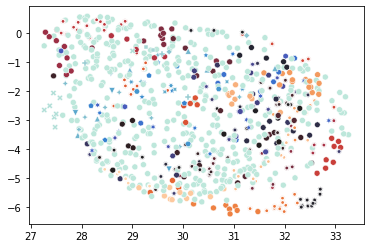

In [47]:
sns.scatterplot(x=z_reduced[:, 0], y=z_reduced[:, 1], hue=preds, style=preds, palette="icefire", legend=False)

In [64]:
tri_mat = np.triu(dists2, 1) # tri_mat.dim=2
tri_mat = tri_mat[np.nonzero(tri_mat)] # tri_mat.dim=1
tri_mat = np.sort(tri_mat,axis=None)
top_num = np.round(0.6*tri_mat.size).astype(int)

In [65]:
eps = tri_mat[:top_num].mean()
eps

0.9575

In [71]:
preds = cluster.DBSCAN(eps=eps, min_samples=2, metric='precomputed', n_jobs=8).fit_predict(dists2)

In [72]:
np.unique(preds, return_counts=True)

(array([0]), array([800]))

In [77]:
re_ranking(z_reduced, z_reduced, k1=20, k2=6, lambda_value=0)

computing original distance
starting re_ranking


array([[-1.953e-03,  1.000e+00,  1.000e+00, ...,  1.000e+00,  1.000e+00,
         1.000e+00],
       [ 1.000e+00,  4.883e-04,  1.000e+00, ...,  1.000e+00,  1.000e+00,
         1.000e+00],
       [ 1.000e+00,  1.000e+00,  0.000e+00, ...,  1.000e+00,  1.000e+00,
         1.000e+00],
       ...,
       [ 1.000e+00,  1.000e+00,  1.000e+00, ..., -1.953e-03,  1.000e+00,
         1.000e+00],
       [ 1.000e+00,  1.000e+00,  1.000e+00, ...,  1.000e+00,  0.000e+00,
         1.000e+00],
       [ 1.000e+00,  1.000e+00,  1.000e+00, ...,  1.000e+00,  1.000e+00,
         0.000e+00]], dtype=float16)